# Mini-projet Probabilités — Test du GCL **RANDU**


## Introduction

Ce notebook teste le générateur congruentiel linéaire (GCL) **RANDU** avec les paramètres suivants :
- $x_{n+1} \equiv (65539 \times x_n) \mod 2^{31}$
- $x_0 = 12345$

Nous allons tester ce générateur avec trois tailles d'échantillons :
- 30 000 données
- 90 000 données
- 300 000 données

Les tests appliqués sont :
1. **Test du khi-deux** (seuil de confiance à 1%)
2. **Test spectral 2D** (sur des doublets)
3. **Test spectral 3D** (sur des triplets)

## 1. Importation des bibliothèques

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

ModuleNotFoundError: No module named 'scipy'

## 2. Implémentation du générateur RANDU

In [2]:
#1.À partir de ce GCL générer une suite de nombre dans l’intervalle [0,1].

def randu(n, x0=12345):
    a = 65539
    m = 2**31
    x = x0
    liste = []
    for i in range(n):
        x = (a * x) % m         
        liste.append(x / m)       
    return liste

valeurs = randu(5)
print(valeurs)



[0.37675674771890044, 0.2604887490160763, 0.17212176462635398, 0.6883318466134369, 0.5808951980434358]


## 3. Test du Khi-deux (χ²)

Le test du khi-deux vérifie si la distribution des nombres générés suit une distribution uniforme.
En outre est-ce que les valeurs sont bien réparties entre 0 et 1 ?

Pour un seuil de confiance de 1% (α = 0.01), on rejette l'hypothèse nulle si la statistique χ² est supérieure à la valeur critique.

In [3]:
# --- Test du khi-deux ---
def test_khi2(data):
    N = len(data)          # nombre total de valeurs
    k = 10             # nombre d'intervalles
    counts, bins = np.histogram(data, bins=10) # compte combien de valeurs dans chaque case - Observé Oi
    nbAttendu = N / k        # ce qu'on devrait avoir dans chaque case si uniforme - Ei = N/k
    
    khi2 = np.sum((counts - nbAttendu)**2 / nbAttendu)# Calcul de la statistique du khi-deux

    # Valeur critique à 1% pour 9 degrés de liberté (voir la table du khi2)
    seuil = 21.666

    print("----- Test du Khi-Deux -----")
    print(f"Nombre de valeurs : {N}")
    print(f"Statistique Khi² = {khi2:.2f}")
    print(f"Valeur critique (1%) = {seuil}")
    if khi2 < seuil:
        print("Test réussi : répartition uniforme")
    else:
        print("Test échoué : répartition non uniforme")
    print("-----------------------------")

# --- Exécution du test ---
valeurs = randu(30000)
test_khi2(valeurs)


----- Test du Khi-Deux -----
Nombre de valeurs : 30000
Statistique Khi² = 6.91
Valeur critique (1%) = 21.666
Test réussi : répartition uniforme
-----------------------------


## 4. Test spectral 2D (doublets)

Le test spectral 2D vérifie si les **couples** (u_n, u_{n+1}) forment un nuage **aléatoire** dans le plan.

Si le générateur est bon → les points sont **dispersés partout**
Si le générateur est mauvais → les points forment des **lignes** ou des **motifs**

In [4]:
# Test 2D : on prend des paires de valeurs successives
def test_spectral_2d(data):
    # Prendre les valeurs 2 par 2
    x = data[:-1]  # u_0, u_1, u_2, ...
    y = data[1:]   # u_1, u_2, u_3, ...
    
    # Visualiser les 5000 premiers couples
    plt.figure(figsize=(10, 8))
    plt.scatter(x[:5000], y[:5000], s=1, alpha=0.5)
    plt.xlabel('u_n')
    plt.ylabel('u_{n+1}')
    plt.title('Test 2D : couples (u_n, u_{n+1})')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
    
    print(" Si les points sont bien dispersés → BON générateur")
    print(" Si on voit des lignes ou motifs → MAUVAIS générateur")

## 5. Test spectral 3D (triplets)

Le test spectral 3D vérifie si les **triplets** (u_n, u_{n+1}, u_{n+2}) forment un nuage **aléatoire** dans l'espace 3D.

C'est le test qui **révèle le défaut de RANDU** : les points se placent sur seulement 15 plans parallèles !

In [43]:
# Test 3D : on prend des triplets de valeurs successives
def test_spectral_3d(data):
    # Prendre les valeurs 3 par 3
    x = data[:-2]    # u_0, u_1, u_2, ...
    y = data[1:-1]   # u_1, u_2, u_3, ...
    z = data[2:]     # u_2, u_3, u_4, ...
    
    # Visualiser beaucoup plus de points pour bien voir les plans
    fig = plt.figure(figsize=(14, 11), facecolor='white')
    ax = fig.add_subplot(111, projection='3d', facecolor='white')
    
    # Beaucoup plus de points pour mieux voir les plans
    n_points = 10000
    
    # Points bien visibles avec couleur et dégradé
    scatter = ax.scatter(x[:n_points], y[:n_points], z[:n_points], 
                        s=8, alpha=0.8, c=z[:n_points], 
                        cmap='viridis', edgecolors='none')
    
    ax.set_xlabel('u_n', fontsize=13, labelpad=12, fontweight='bold')
    ax.set_ylabel('u_{n+1}', fontsize=13, labelpad=12, fontweight='bold')
    ax.set_zlabel('u_{n+2}', fontsize=13, labelpad=12, fontweight='bold')
    ax.set_title('Test 3D : triplets (u_n, u_{n+1}, u_{n+2}) - Les 15 plans parallèles de RANDU', 
                 fontsize=15, pad=25, fontweight='bold')
    
    # Vue optimale pour voir les plans parallèles
    ax.view_init(elev=15, azim=45)
    
    # Fond clair avec grille visible
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('gray')
    ax.yaxis.pane.set_edgecolor('gray')
    ax.zaxis.pane.set_edgecolor('gray')
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Ajouter une barre de couleur pour montrer la profondeur
    plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Profondeur (u_{n+2})')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Si les points remplissent tout le cube → BON générateur")
    print("❌ Si on voit des PLANS PARALLÈLES → MAUVAIS générateur (c'est le cas de RANDU !)")
    print(f"📊 {n_points} points affichés pour visualiser la structure")


## 6. Tests sur 30 000 données

In [6]:
print("="*70)
print("TESTS AVEC 30 000 DONNÉES")
print("="*70)

# Génération des données
data_30k = np.array(randu(30000, 12345))  # Convertir en array NumPy

print(f"\n✓ Généré {len(data_30k)} nombres")
print(f"  Min: {data_30k.min():.6f}, Max: {data_30k.max():.6f}")
print(f"  Moyenne: {data_30k.mean():.6f} (attendu: 0.5)")
print(f"  Écart-type: {data_30k.std():.6f} (attendu: {1/np.sqrt(12):.6f})")

TESTS AVEC 30 000 DONNÉES

✓ Généré 30000 nombres
  Min: 0.000007, Max: 0.999996
  Moyenne: 0.500953 (attendu: 0.5)
  Écart-type: 0.288112 (attendu: 0.288675)


### 6.1. Test du Khi-deux (30 000 données)


----------------------------------------------------------------------
TEST DU KHI-DEUX (30 000 données)
----------------------------------------------------------------------

----- Test du Khi-Deux -----
Nombre de valeurs : 30000
Statistique Khi² = 6.91
Valeur critique (1%) = 21.666
Test réussi : répartition uniforme
-----------------------------


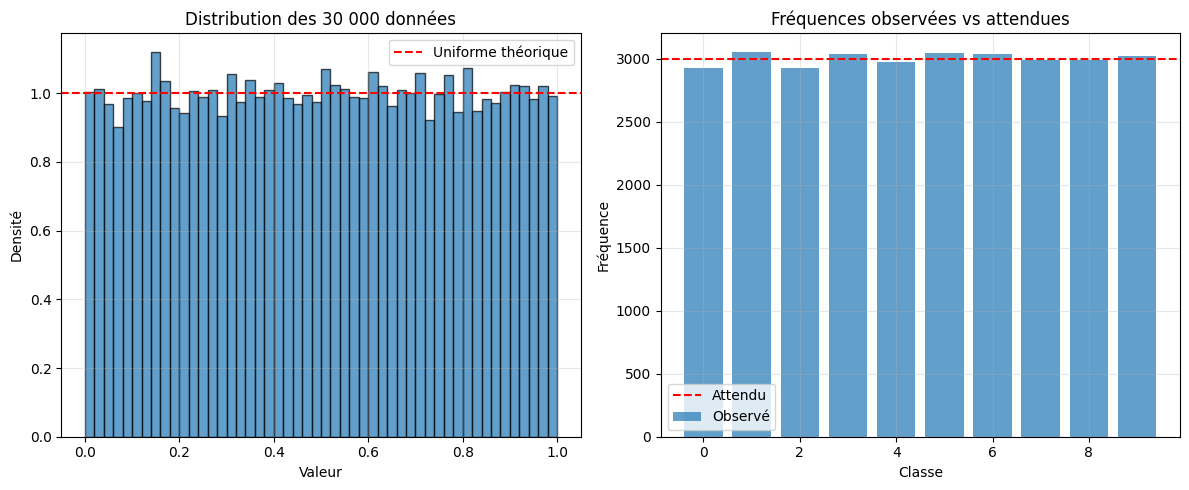

In [7]:
print("\n" + "-"*70)
print("TEST DU KHI-DEUX (30 000 données)")
print("-"*70 + "\n")

# Utiliser la fonction test_khi2 que vous avez déjà définie
test_khi2(data_30k)

# Visualisation de la distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(data_30k, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axhline(y=1, color='r', linestyle='--', label='Uniforme théorique')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.title('Distribution des 30 000 données')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
observed, bins = np.histogram(data_30k, bins=10, range=(0, 1))
expected = len(data_30k) / 10
plt.bar(range(10), observed, alpha=0.7, label='Observé')
plt.axhline(y=expected, color='r', linestyle='--', label='Attendu')
plt.xlabel('Classe')
plt.ylabel('Fréquence')
plt.title('Fréquences observées vs attendues')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2. Test spectral 2D (30 000 données)


----------------------------------------------------------------------
TEST SPECTRAL 2D (30 000 données)
----------------------------------------------------------------------



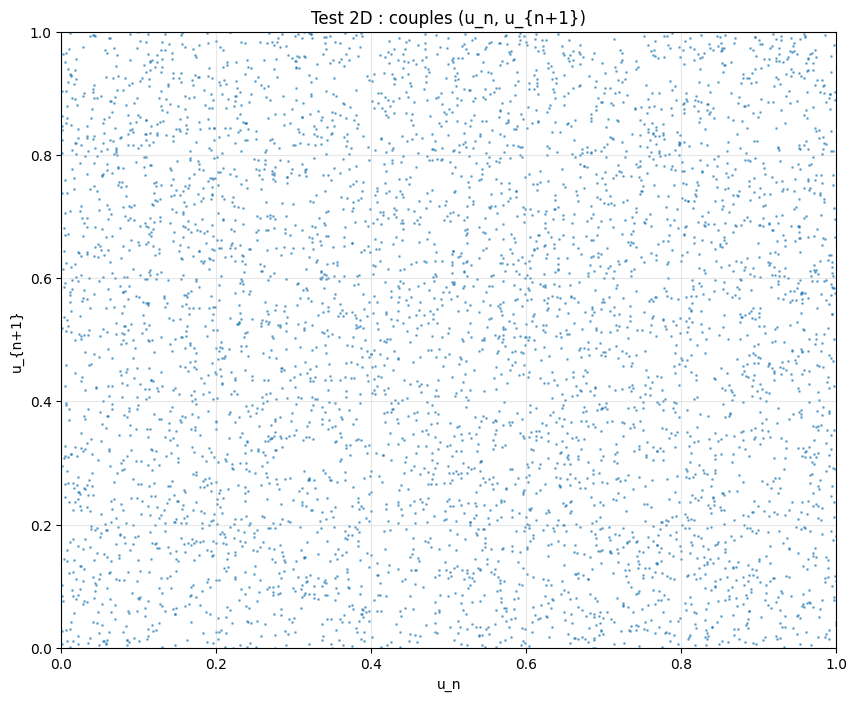

 Si les points sont bien dispersés → BON générateur
 Si on voit des lignes ou motifs → MAUVAIS générateur


In [8]:
print("\n" + "-"*70)
print("TEST SPECTRAL 2D (30 000 données)")
print("-"*70 + "\n")

test_spectral_2d(data_30k)

### 6.3. Test spectral 3D (30 000 données)

In [34]:
print("\n" + "-"*70)
print("TEST SPECTRAL 3D (30 000 données)")
print("-"*70 + "\n")

test_spectral_3d(data_30k)


----------------------------------------------------------------------
TEST SPECTRAL 3D (30 000 données)
----------------------------------------------------------------------



NameError: name 'data_30k' is not defined

## 7. Tests sur 90 000 données

In [10]:
print("\n\n" + "="*70)
print("TESTS AVEC 90 000 DONNÉES")
print("="*70)

# Génération des données
data_90k = np.array(randu(90000, 12345))

print(f"\n✓ Généré {len(data_90k)} nombres")
print(f"  Min: {data_90k.min():.6f}, Max: {data_90k.max():.6f}")
print(f"  Moyenne: {data_90k.mean():.6f} (attendu: 0.5)")
print(f"  Écart-type: {data_90k.std():.6f} (attendu: {1/np.sqrt(12):.6f})")



TESTS AVEC 90 000 DONNÉES

✓ Généré 90000 nombres
  Min: 0.000007, Max: 0.999996
  Moyenne: 0.501087 (attendu: 0.5)
  Écart-type: 0.288408 (attendu: 0.288675)


### 7.1. Test du Khi-deux (90 000 données)

In [11]:
print("\n" + "-"*70)
print("TEST DU KHI-DEUX (90 000 données)")
print("-"*70 + "\n")

test_khi2(data_90k)


----------------------------------------------------------------------
TEST DU KHI-DEUX (90 000 données)
----------------------------------------------------------------------

----- Test du Khi-Deux -----
Nombre de valeurs : 90000
Statistique Khi² = 8.85
Valeur critique (1%) = 21.666
Test réussi : répartition uniforme
-----------------------------


### 7.2. Test spectral 2D (90 000 données)


----------------------------------------------------------------------
TEST SPECTRAL 2D (90 000 données)
----------------------------------------------------------------------



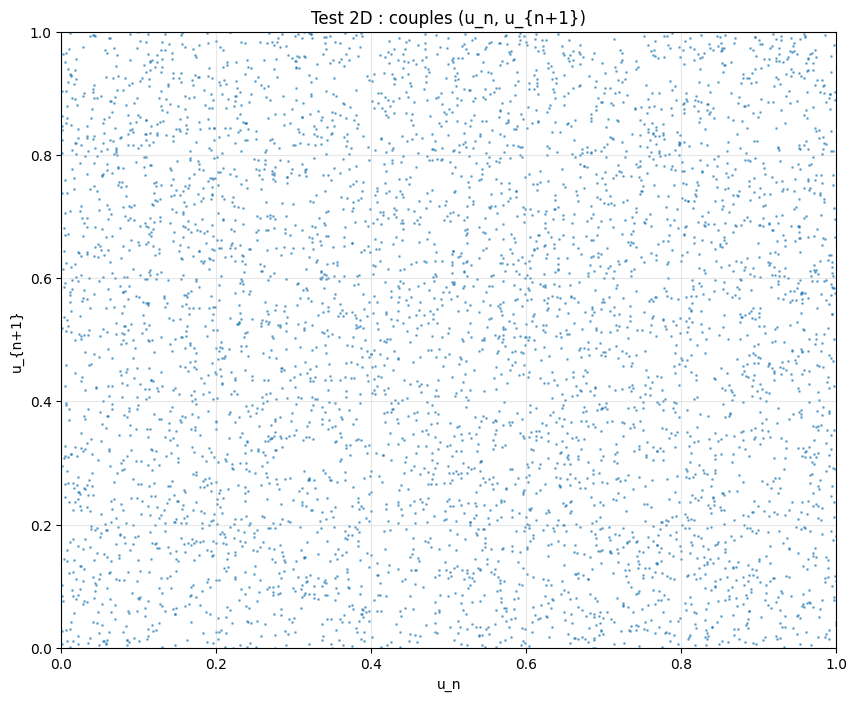

 Si les points sont bien dispersés → BON générateur
 Si on voit des lignes ou motifs → MAUVAIS générateur


In [12]:
print("\n" + "-"*70)
print("TEST SPECTRAL 2D (90 000 données)")
print("-"*70 + "\n")

test_spectral_2d(data_90k)

### 7.3. Test spectral 3D (90 000 données)


----------------------------------------------------------------------
TEST SPECTRAL 3D (90 000 données)
----------------------------------------------------------------------



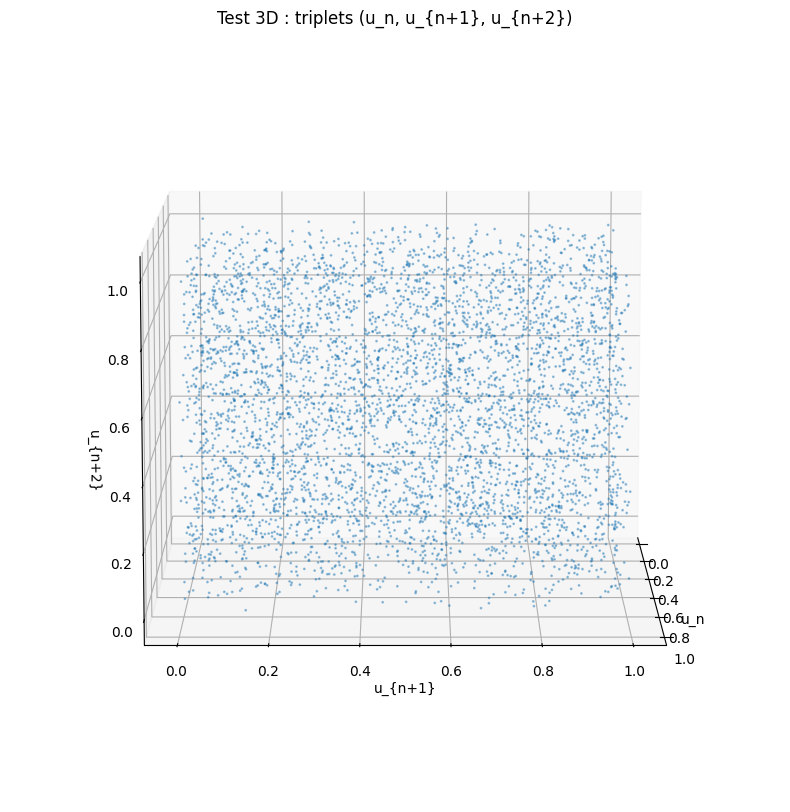

✅ Si les points remplissent tout le cube → BON générateur
❌ Si on voit des PLANS PARALLÈLES → MAUVAIS générateur (c'est le cas de RANDU !)


In [13]:
print("\n" + "-"*70)
print("TEST SPECTRAL 3D (90 000 données)")
print("-"*70 + "\n")

test_spectral_3d(data_90k)

## 8. Tests sur 300 000 données

In [14]:
print("\n\n" + "="*70)
print("TESTS AVEC 300 000 DONNÉES")
print("="*70)

# Génération des données
data_300k = np.array(randu(300000, 12345))

print(f"\n✓ Généré {len(data_300k)} nombres")
print(f"  Min: {data_300k.min():.6f}, Max: {data_300k.max():.6f}")
print(f"  Moyenne: {data_300k.mean():.6f} (attendu: 0.5)")
print(f"  Écart-type: {data_300k.std():.6f} (attendu: {1/np.sqrt(12):.6f})")



TESTS AVEC 300 000 DONNÉES

✓ Généré 300000 nombres
  Min: 0.000005, Max: 0.999997
  Moyenne: 0.500806 (attendu: 0.5)
  Écart-type: 0.288707 (attendu: 0.288675)


### 8.1. Test du Khi-deux (300 000 données)

In [15]:
print("\n" + "-"*70)
print("TEST DU KHI-DEUX (300 000 données)")
print("-"*70 + "\n")

test_khi2(data_300k)


----------------------------------------------------------------------
TEST DU KHI-DEUX (300 000 données)
----------------------------------------------------------------------

----- Test du Khi-Deux -----
Nombre de valeurs : 300000
Statistique Khi² = 5.49
Valeur critique (1%) = 21.666
Test réussi : répartition uniforme
-----------------------------


### 8.2. Test spectral 2D (300 000 données)


----------------------------------------------------------------------
TEST SPECTRAL 2D (300 000 données)
----------------------------------------------------------------------



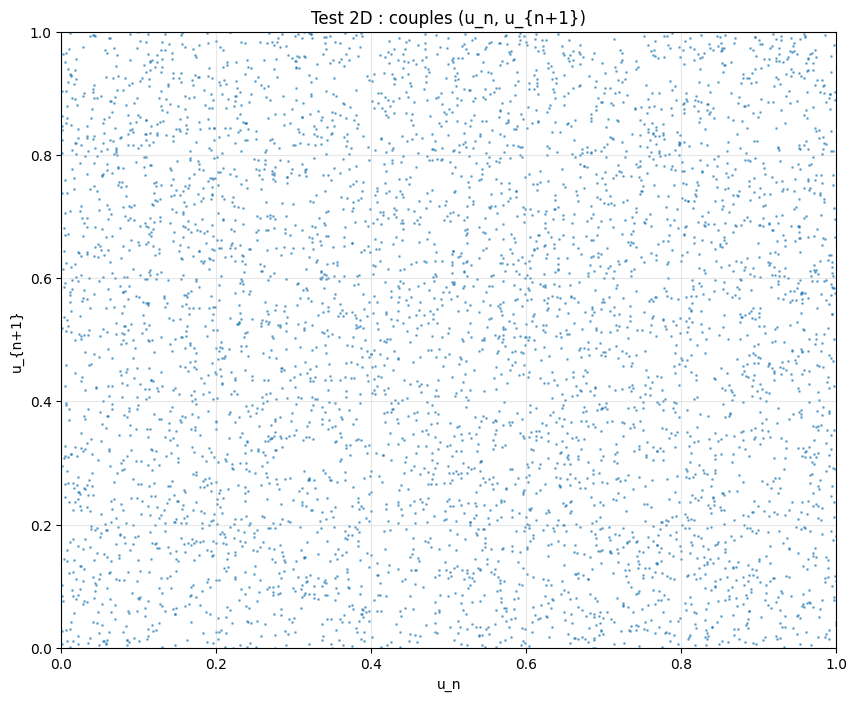

 Si les points sont bien dispersés → BON générateur
 Si on voit des lignes ou motifs → MAUVAIS générateur


In [15]:
print("\n" + "-"*70)
print("TEST SPECTRAL 2D (300 000 données)")
print("-"*70 + "\n")

test_spectral_2d(data_300k)

### 8.3. Test spectral 3D (300 000 données)


----------------------------------------------------------------------
TEST SPECTRAL 3D (300 000 données)
----------------------------------------------------------------------



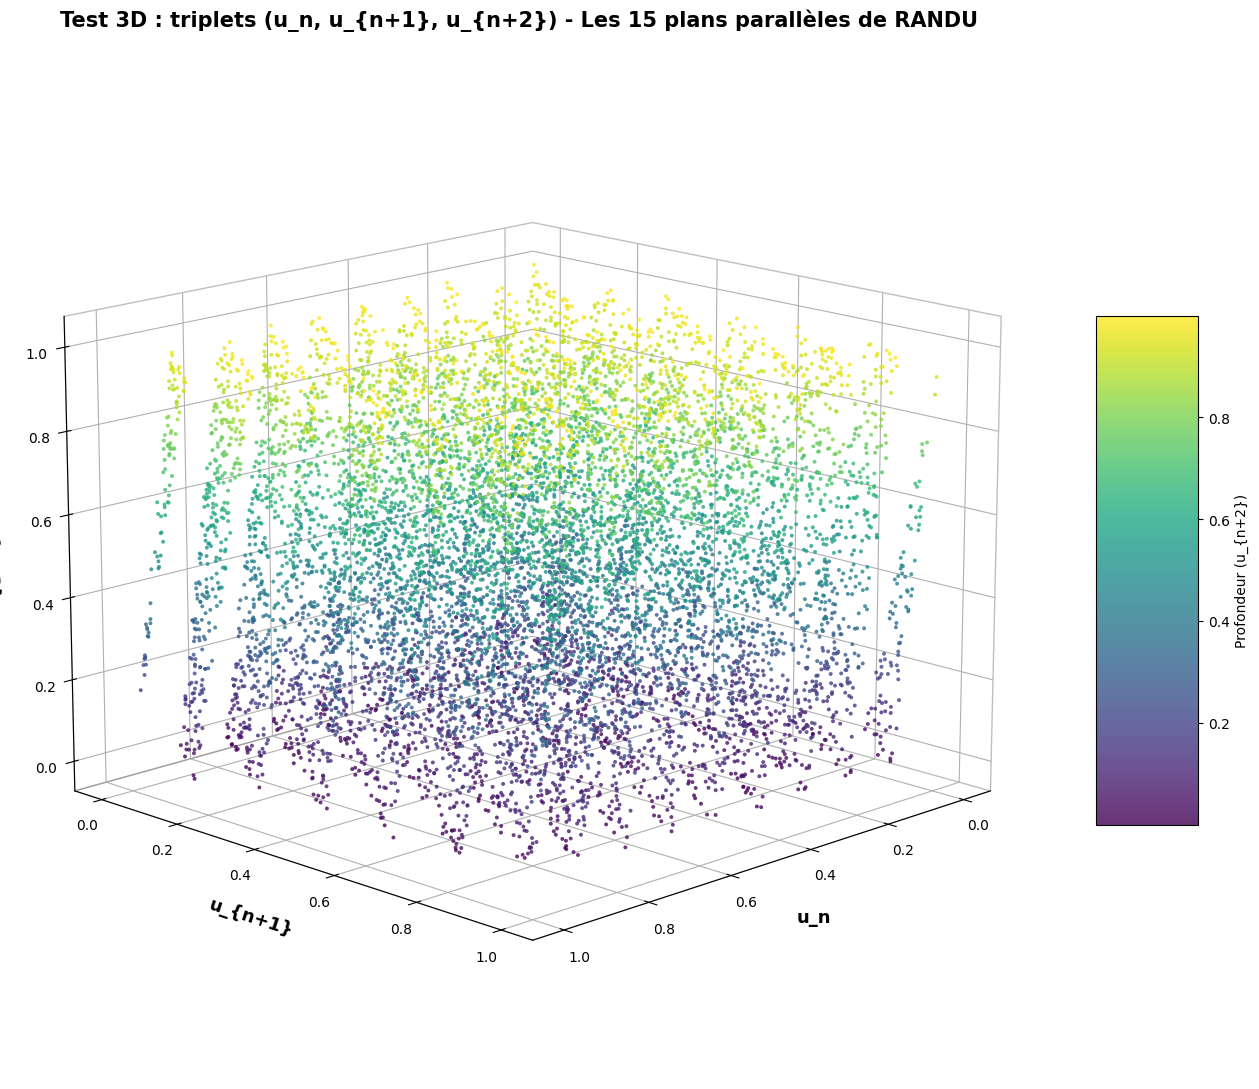

✅ Si les points remplissent tout le cube → BON générateur
❌ Si on voit des PLANS PARALLÈLES → MAUVAIS générateur (c'est le cas de RANDU !)
📊 10000 points affichés pour visualiser la structure


In [44]:
print("\n" + "-"*70)
print("TEST SPECTRAL 3D (300 000 données)")
print("-"*70 + "\n")

test_spectral_3d(data_300k)

## 9. Synthèse des résultats

In [ ]:
print("\n\n" + "="*70)
print("CONCLUSION GÉNÉRALE")
print("="*70)
print("""
✅ Test du Khi-deux : RANDU peut passer ce test
   → Les valeurs individuelles semblent bien réparties entre 0 et 1

❌ Tests spectraux (2D et 3D) : RANDU ÉCHOUE
   → En 3D, les triplets forment seulement 15 PLANS PARALLÈLES !
   → Ce n'est PAS du tout aléatoire !

⚠️  CONCLUSION : RANDU est un MAUVAIS générateur
    Ne JAMAIS l'utiliser dans des vraies applications !
""")

## 10. Comparaison avec un générateur de référence (bonus)

Pour mieux comprendre les défauts de RANDU, comparons-le avec le générateur de NumPy (Mersenne Twister / PCG64).

In [ ]:
print("="*70)
print("COMPARAISON: RANDU vs NumPy (générateur de qualité)")
print("="*70)

# Générer des données avec NumPy (un BON générateur)
np.random.seed(12345)
data_numpy = np.random.random(30000)

# Comparer en 3D
fig = plt.figure(figsize=(16, 6))

# RANDU (MAUVAIS)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
n = 5000
ax1.scatter(data_30k[:-2][:n], data_30k[1:-1][:n], data_30k[2:][:n], s=1, alpha=0.4)
ax1.set_xlabel('u_n')
ax1.set_ylabel('u_{n+1}')
ax1.set_zlabel('u_{n+2}')
ax1.set_title('❌ RANDU - Plans parallèles visibles')

# NumPy (BON)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(data_numpy[:-2][:n], data_numpy[1:-1][:n], data_numpy[2:][:n], s=1, alpha=0.4)
ax2.set_xlabel('u_n')
ax2.set_ylabel('u_{n+1}')
ax2.set_zlabel('u_{n+2}')
ax2.set_title('✅ NumPy - Répartition uniforme')

plt.tight_layout()
plt.show()

print("\n👉 Différence ÉVIDENTE : RANDU a des plans, NumPy remplit tout l'espace !")